# Scope Classification for News article using BERT

This notebook was developped in a Google collab environment.

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import BertForSequenceClassification, LongformerTokenizer, LongformerForSequenceClassification
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import time

In [ ]:
df = pd.read_csv('scope_dataset.csv').sample(frac = 1).reset_index(drop = True)
df.head()

,text,label
0,By Tim Reynolds | The Associated Press UPDATE ...,0
1,IndonesiaExecutive Summary The review: The Re...,1
2,Back to back earthquakes measuring magnitude 7...,0
3,Last modified on Tue 13 Mar 2018 18.26 GMT Jus...,1
4,"Residents in parts of Laguna Beach, California...",1


In [ ]:
df.label.mean()

0.7323741007194244

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [label for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
np.random.seed(112)
df_train, df_val = train_test_split(df, test_size=0.15, shuffle = True, random_state=1, stratify = df.label.values)
print(len(df_train),len(df_val))

590 105


In [ ]:
def train(model, train_data, val_data, learning_rate, epochs, list_list_labels_train = [], list_list_preds_train = [], list_list_labels_val = [], list_list_preds_val = []):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=4)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Device :', device)

    prop = train_data.label.mean()
    criterion = nn.CrossEntropyLoss(weight = torch.tensor([prop, 1 - prop]))

    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0
            list_labels_train = []
            list_preds_train = []


            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.type(torch.LongTensor)
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask).logits
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()

                for el in train_label :
                  list_labels_train.append(el.item())
                for el in output.argmax(dim=1):
                  list_preds_train.append(el.item())
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            
            list_list_labels_train.append(list_labels_train)
            list_list_preds_train.append(list_preds_train)

            total_acc_val = 0
            total_loss_val = 0
            list_labels_val = []
            list_preds_val = []

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask).logits

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()

                    for el in val_label :
                      list_labels_val.append(el.item())
                    for el in output.argmax(dim=1):
                      list_preds_val.append(el.item())
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            acc_train.append((total_acc_train / len(train_data)))
            acc_val.append((total_acc_val / len(val_data)))
            list_list_labels_val.append(list_labels_val)
            list_list_preds_val.append(list_preds_val)

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            print()

    
    return acc_train, acc_val, list_list_labels_train, list_list_preds_train, list_list_labels_val, list_list_preds_val
                  

def get_scores(list_list_labels_train, list_list_preds_train, list_list_labels_val, list_list_preds_val):
  acc_train = []
  acc_val = []
  prec_train = []
  prec_val = []
  rec_train = []
  rec_val = []
  f1_train = []
  f1_val = []
  for i in range(len(list_list_labels_train)):
    acc_train.append(metrics.accuracy_score(list_list_labels_train[i], list_list_preds_train[i]))
    acc_val.append(metrics.accuracy_score(list_list_labels_val[i], list_list_preds_val[i]))

    prec_train.append(metrics.precision_score(list_list_labels_train[i], list_list_preds_train[i]))
    prec_val.append(metrics.precision_score(list_list_labels_val[i], list_list_preds_val[i]))

    rec_train.append(metrics.recall_score(list_list_labels_train[i], list_list_preds_train[i]))
    rec_val.append(metrics.recall_score(list_list_labels_val[i], list_list_preds_val[i]))

    f1_train.append(metrics.f1_score(list_list_labels_train[i], list_list_preds_train[i]))
    f1_val.append(metrics.f1_score(list_list_labels_val[i], list_list_preds_val[i]))
  return acc_train, acc_val, prec_train, prec_val, rec_train, rec_val, f1_train, f1_val

def show_scores(acc_train, acc_val, prec_train, prec_val, rec_train, rec_val, f1_train, f1_val):
  sns.set()

  fig, axs = plt.subplots(2, 2, figsize = (14,8))


  axs[0, 0].plot(acc_train, label="Train")
  axs[0, 0].plot(acc_val, label="Test")
  axs[0, 0].set(xlabel='Epoch', ylabel='Accuracy')
  axs[0, 0].legend()

  axs[0, 1].plot(prec_train, label="Train")
  axs[0, 1].plot(prec_val, label="Test")
  axs[0, 1].set(xlabel='Epoch', ylabel='Precision')
  axs[0, 1].legend()

  axs[1, 0].plot(rec_train, label="Train")
  axs[1, 0].plot(rec_val, label="Test")
  axs[1, 0].set(xlabel='Epoch', ylabel='Recall')
  axs[1, 0].legend()

  axs[1, 1].plot(f1_train, label="Train")
  axs[1, 1].plot(f1_val, label="Test")
  axs[1, 1].set(xlabel='Epoch', ylabel='F1 Score')
  axs[1, 1].legend()


In [ ]:
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=2)
acc_train = []
acc_val = []

Downloading:   0%|          | 0.00/570M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weigh

In [ ]:
EPOCHS = 12
LR = 1e-5
              
acc_train, acc_val, list_labels_train, list_preds_train, list_labels_val, list_preds_val = train(model, df_train, df_val, LR, EPOCHS, acc_train, acc_val)

Device : cuda


100%|██████████| 148/148 [03:54<00:00,  1.58s/it]


Epochs: 1 | Train Loss:  0.167                 | Train Accuracy:  0.715                 | Val Loss:  0.175                 | Val Accuracy:  0.686



100%|██████████| 148/148 [03:51<00:00,  1.56s/it]


Epochs: 2 | Train Loss:  0.133                 | Train Accuracy:  0.768                 | Val Loss:  0.162                 | Val Accuracy:  0.638



100%|██████████| 148/148 [03:50<00:00,  1.56s/it]


Epochs: 3 | Train Loss:  0.068                 | Train Accuracy:  0.900                 | Val Loss:  0.216                 | Val Accuracy:  0.619



100%|██████████| 148/148 [03:51<00:00,  1.56s/it]


Epochs: 4 | Train Loss:  0.028                 | Train Accuracy:  0.968                 | Val Loss:  0.278                 | Val Accuracy:  0.705



100%|██████████| 148/148 [03:50<00:00,  1.56s/it]


Epochs: 5 | Train Loss:  0.014                 | Train Accuracy:  0.988                 | Val Loss:  0.321                 | Val Accuracy:  0.676



100%|██████████| 148/148 [03:50<00:00,  1.56s/it]


Epochs: 6 | Train Loss:  0.006                 | Train Accuracy:  0.995                 | Val Loss:  0.425                 | Val Accuracy:  0.752



100%|██████████| 148/148 [03:50<00:00,  1.56s/it]


Epochs: 7 | Train Loss:  0.005                 | Train Accuracy:  0.993                 | Val Loss:  0.350                 | Val Accuracy:  0.676



100%|██████████| 148/148 [03:50<00:00,  1.56s/it]


Epochs: 8 | Train Loss:  0.009                 | Train Accuracy:  0.988                 | Val Loss:  0.421                 | Val Accuracy:  0.752



100%|██████████| 148/148 [03:50<00:00,  1.56s/it]


Epochs: 9 | Train Loss:  0.002                 | Train Accuracy:  0.997                 | Val Loss:  0.429                 | Val Accuracy:  0.752



100%|██████████| 148/148 [03:50<00:00,  1.56s/it]


Epochs: 10 | Train Loss:  0.001                 | Train Accuracy:  0.998                 | Val Loss:  0.450                 | Val Accuracy:  0.743



100%|██████████| 148/148 [03:50<00:00,  1.56s/it]


Epochs: 11 | Train Loss:  0.001                 | Train Accuracy:  0.998                 | Val Loss:  0.472                 | Val Accuracy:  0.743



100%|██████████| 148/148 [03:50<00:00,  1.56s/it]


Epochs: 12 | Train Loss:  0.001                 | Train Accuracy:  0.998                 | Val Loss:  0.485                 | Val Accuracy:  0.743



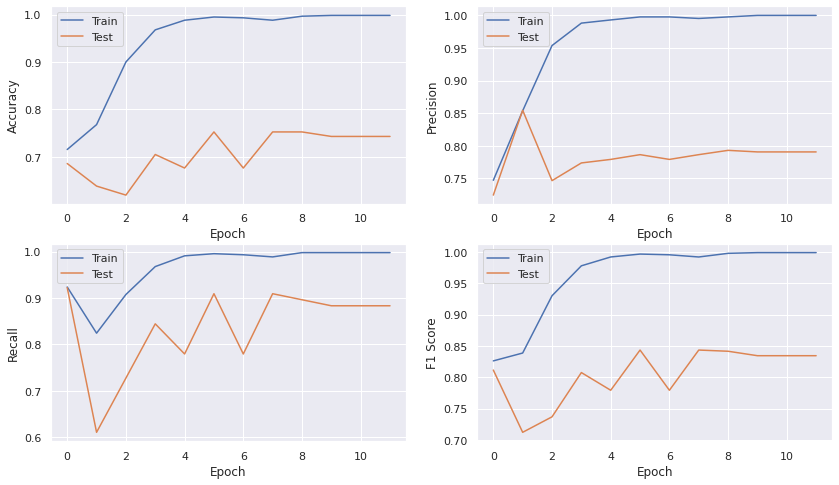

In [ ]:
list_labels_train = [el for el in list_labels_train if type(el) == list]
list_preds_train = [el for el in list_preds_train if type(el) == list]
acc_train, acc_val, prec_train, prec_val, rec_train, rec_val, f1_train, f1_val = get_scores(list_labels_train[:15], list_preds_train[:15], list_labels_val[:15], list_preds_val[:15])
show_scores(acc_train, acc_val, prec_train, prec_val, rec_train, rec_val, f1_train, f1_val)

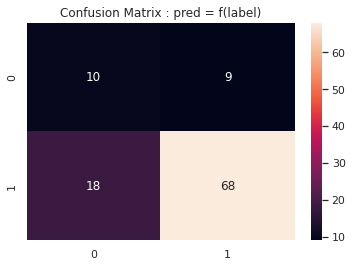

In [ ]:
y_true = list_labels_val[-1]
y_pred = list_preds_val[-1]

sns.heatmap(confusion_matrix(y_pred, y_true), annot=True).set_title("Confusion Matrix : pred = f(label)")
plt.show()

In [ ]:
df_val.label.count() - df_val.label.sum(), df_val.label.sum()

In [ ]:
df_train.label.mean(), df_val.label.mean()

(0.7322033898305085, 0.7333333333333333)

In [ ]:
#save model
torch.save(model, 'longformer_finetuned')